# Deep Learning, Linear Layers, and PCA/ICA

Thomas Breuel

In [132]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")

import torch
from torchmore import flex
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from tutlib.pcaica import showgrid, N

def normalize(x):
    return (x - x.mean()) / x.std()

train_ds = list(datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor()))
images = torch.stack([x[0] for x in train_ds])
mimage = images.mean(0)
train_ds = [(x-mimage, y) for x, y in train_ds]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Reconstruction ICA

## Reconstruction ICA (RICA) Definition

ICA is an odd data transformation because it doesn't make reference to actually preserving any of the data. We can come up with an alternative definition based on _reconstruction loss_:

$\hat{W} = \arg\min_w \lambda ||W X||_1 + || W^T W x - x ||^2_2$

We may still constraint $W^T W = \mathbb{1}$.

- For $\lambda \rightarrow \infty$ and whitened data, this is equivalent to ICA.
- For $\lambda = 0$, this is simply PCA or a linear autoencoder.

This can be implemented directly as a neural network.

In [202]:
l = 0.1
weight = torch.nn.Parameter(0.001 * torch.randn(100, 784, device=device))
optimizer = torch.optim.RMSprop([weight], lr=1e-4, momentum=0.9)
for epoch in range(101):
    losses = []
    for xs, _ in DataLoader(train_ds, batch_size=256, shuffle=True):
        optimizer.zero_grad()
        xs = xs.view(-1, 784).to(device)
        latent = weight @ xs.T
        recon = latent.T @ weight
        loss_recon = ((recon - xs)**2).sum() / xs.shape[0]
        loss_latent = latent.abs().sum() / xs.shape[0]
        loss = loss_recon + l * loss_latent
        loss.backward()
        optimizer.step()
        losses.append((loss.item(), loss_recon.item(), loss_latent.item()))
    if epoch % 10 == 0:
        losses = tuple(np.mean(losses, 0))
        print(epoch, "%.2f %.2f %.2f" % losses)

0 16.97 12.24 47.32
10 8.86 4.64 42.20
20 8.74 4.64 41.01
30 8.70 4.64 40.62
40 8.68 4.64 40.41
50 8.67 4.64 40.29
60 8.66 4.64 40.18
70 8.65 4.64 40.12
80 8.65 4.64 40.08
90 8.65 4.64 40.04
100 8.64 4.64 40.02


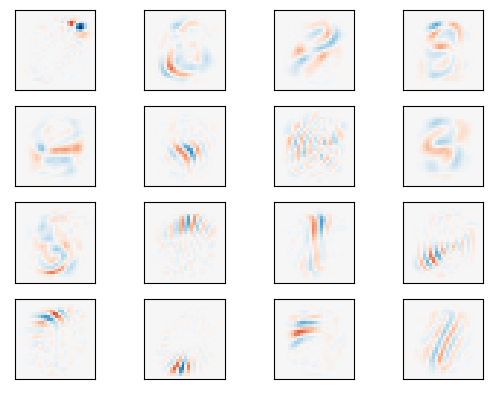

In [203]:
m = weight.abs().amax().item()
showgrid(weight, cmap=cm.RdBu, vmin=-m, vmax=m)

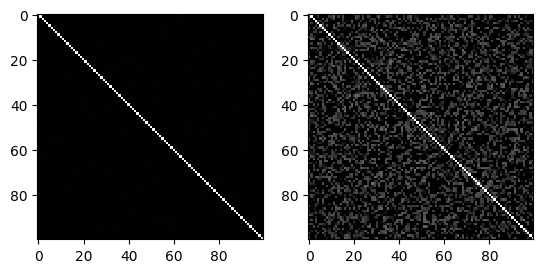

In [204]:
subplot(121)
imshow(N(weight.mm(weight.transpose(1, 0))))
subplot(122)
imshow(np.log10(np.maximum(1e-4, N(weight.mm(weight.transpose(1, 0))))))

# SUMMARY

ICA can be formulated as a "neural learning algorithm" similar to PCA as "RICA"

The loss function in RICA is a combination of reconstruction loss (as in PCA) and an L1 loss on the activation of the encoding.

RICA can smoothly interpolate between optimal reconstruction (PCA) and independent components (ICA).

L1 losses imposed on hidden layers generate sparsity and favor non-Gaussian component selection.